In [52]:
import numpy as np, pandas as pd, networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium, imageio, os
from folium import GeoJson, Popup
from geopandas.tools import sjoin
from scipy.stats import gaussian_kde
import community as community_louvain

# Proyecto 1
## Seminario 2 de Matemática Aplicada
## MM3024 Sección 10
### Jonathan Espinoza 20022
### Jeyner Arango 201106

### Mapeo de CDMX y ECOBICI

In [2]:
#AGEB Urbanas (Áreas geoestadísticas básicas urbanas)
agebs = gpd.read_file('agebs_cdmx.geojson')

In [3]:
agebs.head()

ageb_urbana_cvegeo                                           geometry
0      0900700013628  MULTIPOLYGON (((-99.03887 19.39128, -99.03851 ...
1      0900300011533  MULTIPOLYGON (((-99.18010 19.30772, -99.17845 ...
2      0901500010235  MULTIPOLYGON (((-99.14495 19.45625, -99.14536 ...
3      0900200010097  MULTIPOLYGON (((-99.20573 19.50454, -99.20630 ...
4      0900200011184  MULTIPOLYGON (((-99.20723 19.50387, -99.20652 ...

In [4]:
agebs.iloc[0,:]

ageb_urbana_cvegeo                                        0900700013628
geometry              MULTIPOLYGON (((-99.03887376191602 19.39127798...
Name: 0, dtype: object

<Axes: >

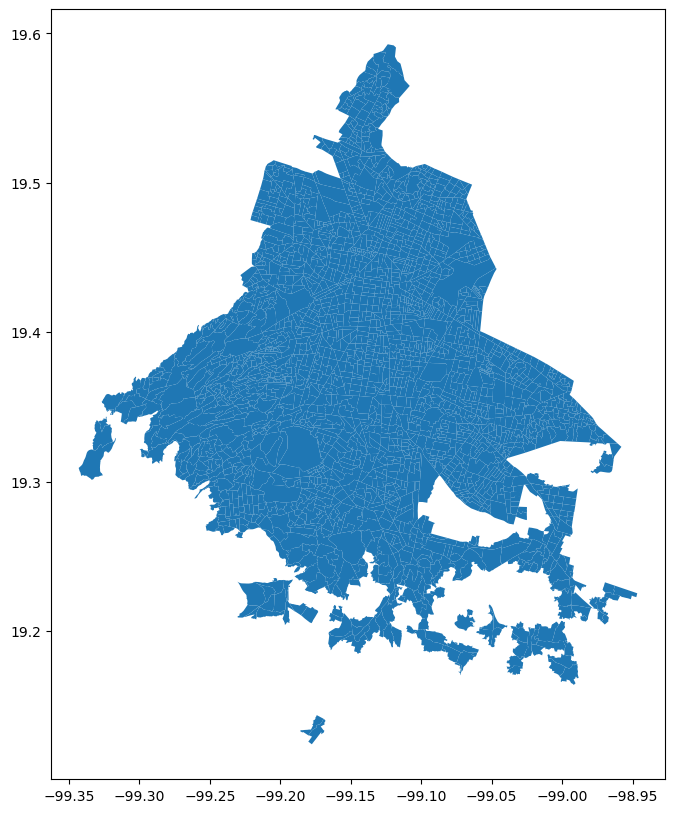

In [5]:
agebs.plot(figsize = (10,10))

In [6]:
# Lee los datos de las estaciones de bicicletas desde el archivo CSV
ciudad_mexico = agebs
estaciones_df = pd.read_csv('stations.csv')

# Convierte el DataFrame en un GeoDataFrame
estaciones_gdf = gpd.GeoDataFrame(estaciones_df, 
                                   geometry=gpd.points_from_xy(estaciones_df.lon, estaciones_df.lat))

estaciones_gdf.head()

id        lat        lon                           name  \
0   1  19.433571 -99.167809          1 RIO SENA-RIO BALSAS   
1   2  19.431386 -99.171695  2 RIO GUADALQUIVIR-RIO BALSAS   
2   3  19.431655 -99.158668          3 REFORMA-INSURGENTES   
3   4  19.428309 -99.171713          4 RIO NILO-RIO PANUCO   
4   5  19.429720 -99.169363         5 RIO PANUCO-RIO TIBER   

                     geometry  
0  POINT (-99.16781 19.43357)  
1  POINT (-99.17169 19.43139)  
2  POINT (-99.15867 19.43165)  
3  POINT (-99.17171 19.42831)  
4  POINT (-99.16936 19.42972)

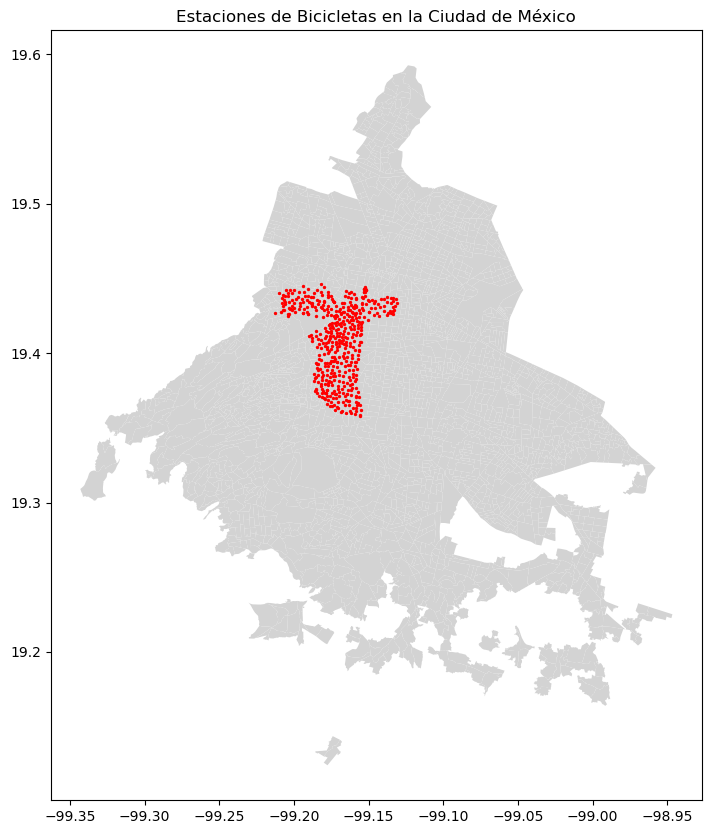

In [7]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Estaciones de Bicicletas en la Ciudad de México')

# Plotea las estaciones
ciudad_mexico.plot(ax=ax, color='lightgrey')
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Muestra el mapa
plt.show()

### Detección de AGEBS relevantes

In [8]:
clave_agebs = pd.read_excel('ClaveAgeb.xlsx')
clave_agebs.head()

Entidad       Municipio  ClaveLoc  \
0  Aguascalientes  Aguascalientes  10010001   
1  Aguascalientes  Aguascalientes  10010293   
2  Aguascalientes  Aguascalientes  10010001   
3  Aguascalientes  Aguascalientes  10010479   
4  Aguascalientes  Aguascalientes  10010357   

                                   Localidad     ClaveAgeb  \
0                             Aguascalientes  100100013238   
1                      Norias de Ojocaliente  100102933666   
2                             Aguascalientes  100100013149   
3  Villa Licenciado Jesús Terán (Calvillito)  100104792742   
4                      Norias del Paso Hondo  100103574166   

  Grado de marginalidad  PRIORIDAD  POBTOT  
0                  Alto      84.95    1315  
1              Muy alto      83.35    1738  
2              Muy alto      83.00    1885  
3                  Alto      83.00    1579  
4              Muy alto      82.80    1015

In [9]:
clave_agebs.columns

Index(['Entidad', 'Municipio', 'ClaveLoc', 'Localidad', 'ClaveAgeb',
       'Grado de marginalidad', 'PRIORIDAD', 'POBTOT'],
      dtype='object')

In [10]:
clave_agebs[clave_agebs['Entidad']=='Distrito Federal']['Municipio'].unique()

array(['Tlalpan', 'Xochimilco', 'Milpa Alta', 'Iztapalapa', 'Tláhuac',
       'Gustavo A. Madero', 'Azcapotzalco', 'Cuajimalpa de Morelos',
       'La Magdalena Contreras', 'Iztacalco', 'Cuauhtémoc',
       'Venustiano Carranza', 'Miguel Hidalgo', 'Coyoacán',
       'Benito Juárez', 'Álvaro Obregón'], dtype=object)

In [11]:
municipios_bicicletas = ['Benito Juárez', 'Cuauhtémoc', 'Miguel Hidalgo']

In [12]:
clave_agebs[(clave_agebs['Entidad']=='Distrito Federal') & (clave_agebs['Municipio'].isin(municipios_bicicletas))]

Entidad       Municipio  ClaveLoc       Localidad  \
4732  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4742  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
4765  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4772  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4773  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
...                ...             ...       ...             ...   
5789  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5790  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5791  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5792  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5793  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   

          ClaveAgeb Grado de marginalidad  PRIORIDAD  POBTOT  
4732   901500010771                 Medio      64.50    1154  
4742   901600010020                 Medio      63.25    2089  
4765   901500010818                  Bajo      62.10     249  
4772   901500011271                  Bajo      61.75    1894  
4773   901500011106                  Bajo      61.70    2127  
...             ...                   ...        ...     ...  
5789   901600011118                 Medio       0.00    6149  
5790   901600011137              Muy bajo       0.00    3740  
5791   901600011156                  Bajo       0.00    7599  
5792  090160001118A              Muy bajo       0.00    7418  
5793   901600011334                  Bajo       0.00    3317  

[167 rows x 8 columns]

In [13]:
mapeo_agebs = clave_agebs[(clave_agebs['Entidad']=='Distrito Federal') & (clave_agebs['Municipio'].isin(municipios_bicicletas))]['ClaveLoc'].unique()
mapeo_agebs = ['0' + str(cadena) for cadena in mapeo_agebs]
mapeo_agebs

['090150001', '090160001', '090140001']

In [14]:
mapeo_municipios = {
    '090140001': 'Benito Juárez',
    '090150001': 'Cuauhtémoc',
    '090160001': 'Miguel Hidalgo'
}

In [15]:
zona_interes = agebs[agebs['ageb_urbana_cvegeo'].str.startswith(tuple(mapeo_agebs))].copy()
zona_interes['municipio_cod']= zona_interes['ageb_urbana_cvegeo'].str.slice(0, 9)
zona_interes['municipio'] = zona_interes['municipio_cod'].map(mapeo_municipios)
zona_interes

ageb_urbana_cvegeo                                           geometry  \
2         0901500010235  MULTIPOLYGON (((-99.14495 19.45625, -99.14536 ...   
14        0901600010586  MULTIPOLYGON (((-99.18103 19.43906, -99.17938 ...   
28        0901400010670  MULTIPOLYGON (((-99.14169 19.36929, -99.14159 ...   
35        0901400010172  MULTIPOLYGON (((-99.13535 19.39143, -99.13597 ...   
40        0901400010581  MULTIPOLYGON (((-99.17232 19.38643, -99.17244 ...   
...                 ...                                                ...   
2324      0901600011353  MULTIPOLYGON (((-99.22203 19.43476, -99.22115 ...   
2325      0901600011264  MULTIPOLYGON (((-99.23375 19.40716, -99.23375 ...   
2326      0901600011368  MULTIPOLYGON (((-99.21909 19.43428, -99.21935 ...   
2327      0901600011298  MULTIPOLYGON (((-99.25344 19.40484, -99.25349 ...   
2330      0901600011300  MULTIPOLYGON (((-99.24841 19.39071, -99.24836 ...   

     municipio_cod       municipio  
2        090150001      Cuauhtémoc  
14       090160001  Miguel Hidalgo  
28       090140001   Benito Juárez  
35       090140001   Benito Juárez  
40       090140001   Benito Juárez  
...            ...             ...  
2324     090160001  Miguel Hidalgo  
2325     090160001  Miguel Hidalgo  
2326     090160001  Miguel Hidalgo  
2327     090160001  Miguel Hidalgo  
2330     090160001  Miguel Hidalgo  

[386 rows x 4 columns]

In [16]:
zona_interes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

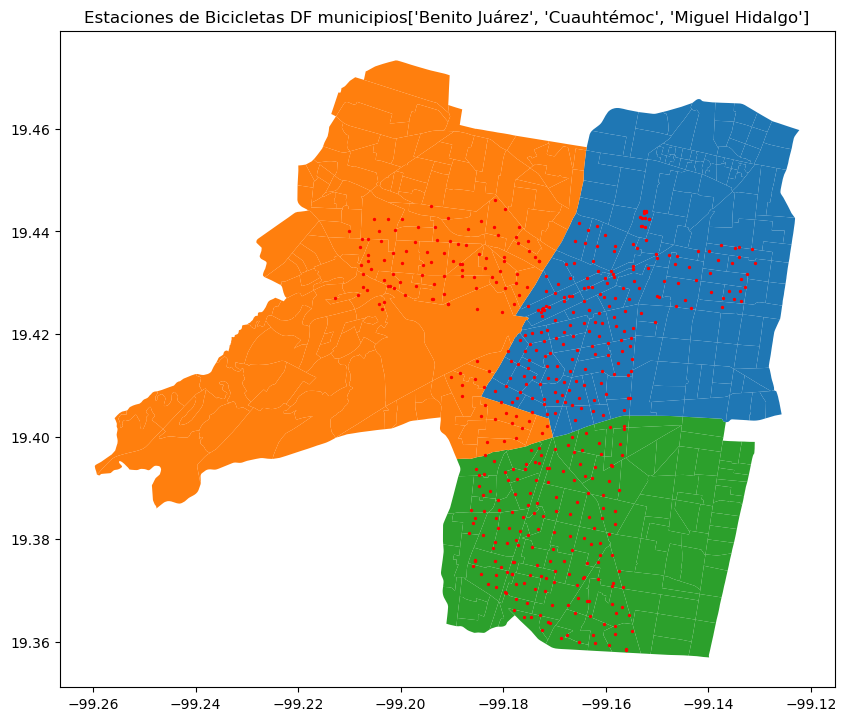

In [17]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))
# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(zona_interes['municipio'].unique(), plt.cm.tab10.colors)}
# Mapeamos los valores de 'municipio' a colores
colores = zona_interes['municipio'].map(colores_por_municipio)
# Ploteamos el DataFrame 'zona_interes' utilizando los colores
ax.set_title('Estaciones de Bicicletas DF municipios' +str(municipios_bicicletas))

# Plotea las estaciones
zona_interes.plot(ax=ax, color=colores)
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Muestra el mapa
plt.show()

In [18]:

crs_proyectado = 'EPSG:32614'

zona_interes_proyectada = zona_interes.to_crs(crs_proyectado)

zona_interes_proyectada['area'] = zona_interes_proyectada.geometry.area

# Suma el área por municipio
area_por_municipio = zona_interes_proyectada.groupby('municipio')['area'].sum() /1000000

# Calcula el área total de todos los polígonos
area_total = zona_interes_proyectada['area'].sum() / 1000000

# Calcula el porcentaje de área de cada municipio con respecto al área total
porcentaje_area_por_municipio = (area_por_municipio / area_total) * 100

# Mostrar el resultado
print("Área por municipio:")
for municipio, area_km2 in area_por_municipio.items():
    print(f'{area_km2:.2f} km² en {municipio}')
# Mostrar el resultado del porcentaje de área por municipio con respecto al área total
print("\nPorcentaje de área por municipio con respecto al área total:")
for municipio, porcentaje in porcentaje_area_por_municipio.items():
    print(f'{porcentaje:.2f}% en {municipio}')

Área por municipio:
26.68 km² en Benito Juárez
32.50 km² en Cuauhtémoc
46.39 km² en Miguel Hidalgo

Porcentaje de área por municipio con respecto al área total:
25.27% en Benito Juárez
30.78% en Cuauhtémoc
43.94% en Miguel Hidalgo


In [19]:
estaciones_gdf = estaciones_gdf.set_crs('EPSG:4326')
estaciones_con_ageb = gpd.sjoin(estaciones_gdf, zona_interes[['ageb_urbana_cvegeo', 'geometry','municipio']], how="left", predicate="within").drop(columns=['index_right'])
estaciones_con_ageb

id        lat        lon                                  name  \
0      1  19.433571 -99.167809                 1 RIO SENA-RIO BALSAS   
1      2  19.431386 -99.171695         2 RIO GUADALQUIVIR-RIO BALSAS   
2      3  19.431655 -99.158668                 3 REFORMA-INSURGENTES   
3      4  19.428309 -99.171713                 4 RIO NILO-RIO PANUCO   
4      5  19.429720 -99.169363                5 RIO PANUCO-RIO TIBER   
..   ...        ...        ...                                   ...   
475  476  19.442127 -99.184433        476 LAGO COMO-LAGUNA DE MAYRÁN   
476  477  19.440905 -99.181743       477 LAGO ISEO-LAGUNA DE MAYRÁN    
477  478  19.440818 -99.176961      478 LAGUNA DE MAYRÁN-LAGO CHALCO   
478  479  19.444433 -99.179664  E479 LAGO MURITZ-AV. MARINA NACIONAL   
479  480  19.446073 -99.181654     480 LAGO ISEO-AV. MARINA NACIONAL   

                       geometry ageb_urbana_cvegeo       municipio  
0    POINT (-99.16781 19.43357)      0901500010790      Cuauhtémoc  
1    POINT (-99.17169 19.43139)      0901500010926      Cuauhtémoc  
2    POINT (-99.15867 19.43165)      0901500010729      Cuauhtémoc  
3    POINT (-99.17171 19.42831)      0901500010926      Cuauhtémoc  
4    POINT (-99.16936 19.42972)      0901500010822      Cuauhtémoc  
..                          ...                ...             ...  
475  POINT (-99.18443 19.44213)      0901600010478  Miguel Hidalgo  
476  POINT (-99.18174 19.44091)      0901600010482  Miguel Hidalgo  
477  POINT (-99.17696 19.44082)      0901600010482  Miguel Hidalgo  
478  POINT (-99.17966 19.44443)      0901600010482  Miguel Hidalgo  
479  POINT (-99.18165 19.44607)      0901600010482  Miguel Hidalgo  

[480 rows x 7 columns]

### Selección de AGEBS

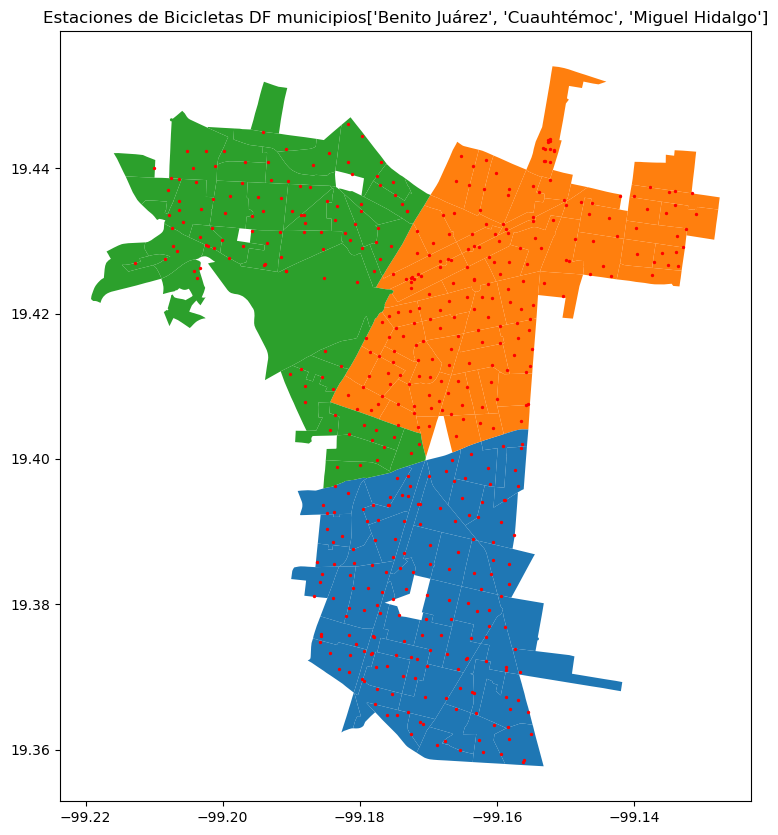

In [20]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Filtra los polígonos de zona_interes que coinciden con los valores de ageb_urbana_cvegeo en estaciones_con_ageb
poligonos_seleccionados = zona_interes[zona_interes['ageb_urbana_cvegeo'].isin(estaciones_con_ageb['ageb_urbana_cvegeo'])]

# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(poligonos_seleccionados['municipio'].unique(), plt.cm.tab10.colors)}

# Mapeamos los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ploteamos el DataFrame 'poligonos_seleccionados' utilizando los colores
poligonos_seleccionados.plot(ax=ax, color=colores)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [21]:
len(poligonos_seleccionados['ageb_urbana_cvegeo'].unique())

144

In [22]:
zona_interes_faltante = zona_interes[zona_interes['ageb_urbana_cvegeo'].isin(['0901500011445', '0901600010586', '0901600010764','0901400010596'])]
poligonos_seleccionados = pd.concat([poligonos_seleccionados, zona_interes_faltante], ignore_index=True)

In [23]:
len(poligonos_seleccionados['ageb_urbana_cvegeo'].unique())

148

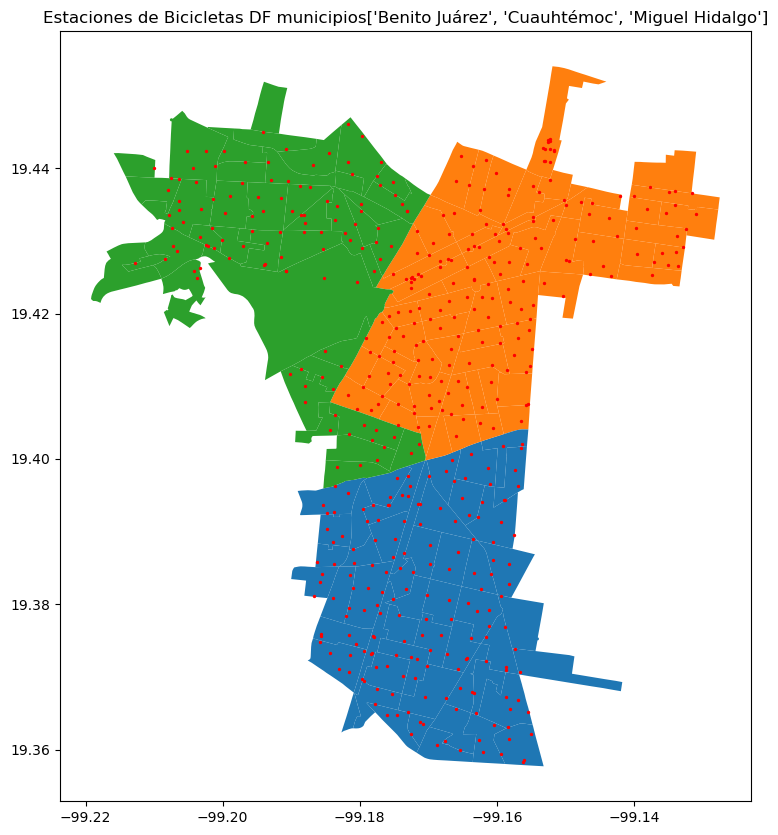

In [24]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(poligonos_seleccionados['municipio'].unique(), plt.cm.tab10.colors)}

# Mapeamos los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ploteamos el DataFrame 'poligonos_seleccionados' utilizando los colores
poligonos_seleccionados.plot(ax=ax, color=colores)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [25]:
poligonos_seleccionados_proyectados = poligonos_seleccionados.to_crs('EPSG:32614')
poligonos_seleccionados_proyectados['area'] = poligonos_seleccionados_proyectados.geometry.area / 1e6  # Convertir de m² a km²
poligonos_seleccionados_proyectados

ageb_urbana_cvegeo                                           geometry  \
0        0901400010581  MULTIPOLYGON (((481905.313 2143595.120, 481892...   
1        0901500011017  MULTIPOLYGON (((483869.067 2147955.234, 483852...   
2        0901400010948  MULTIPOLYGON (((482060.866 2140817.701, 482011...   
3        090150001138A  MULTIPOLYGON (((483228.120 2146329.276, 483232...   
4        0901500011479  MULTIPOLYGON (((483307.166 2145472.916, 483279...   
..                 ...                                                ...   
143      0901600011226  MULTIPOLYGON (((482104.933 2145073.113, 481913...   
144      0901600010586  MULTIPOLYGON (((480996.824 2149419.923, 481170...   
145      0901600010764  MULTIPOLYGON (((479261.946 2148612.067, 479355...   
146      0901400010596  MULTIPOLYGON (((481708.390 2142751.108, 481706...   
147      0901500011445  MULTIPOLYGON (((482520.583 2145193.212, 482452...   

    municipio_cod       municipio      area  
0       090140001   Benito Juárez  0.152425  
1       090150001      Cuauhtémoc  0.391660  
2       090140001   Benito Juárez  0.116166  
3       090150001      Cuauhtémoc  0.250222  
4       090150001      Cuauhtémoc  0.170074  
..            ...             ...       ...  
143     090160001  Miguel Hidalgo  0.215030  
144     090160001  Miguel Hidalgo  0.107973  
145     090160001  Miguel Hidalgo  0.038496  
146     090140001   Benito Juárez  0.217991  
147     090150001      Cuauhtémoc  0.153937  

[148 rows x 5 columns]

In [26]:
poligonos_seleccionados_proyectados['area'].sum()

43.00923446124185

In [27]:
area_total_poligonos_seleccionados_por_municipio = poligonos_seleccionados_proyectados.groupby('municipio')['area'].sum()
area_total_poligonos_seleccionados_por_municipio

municipio
Benito Juárez     14.264150
Cuauhtémoc        14.565977
Miguel Hidalgo    14.179107
Name: area, dtype: float64

In [28]:
cobertura_por_municipio = area_total_poligonos_seleccionados_por_municipio / area_por_municipio * 100
print("\nPorcentaje de cobertura de red de bicicletas respecto al área total por municipio :")
for municipio, porcentaje in cobertura_por_municipio.items():
    print(f'{porcentaje:.2f}% en {municipio}')


Porcentaje de cobertura de red de bicicletas respecto al área total por municipio :
53.46% en Benito Juárez
44.82% en Cuauhtémoc
30.57% en Miguel Hidalgo


### Superposición sobre Open Street Maps

In [29]:
# Crea un mapa centrado en la ubicación de interés
m = folium.Map(location=[19.408970, -99.171276], zoom_start=13)

# Itera sobre cada fila en zona_interes para agregar los polígonos al mapa
for idx, row in poligonos_seleccionados.iterrows():
    # Convierte el polígono a GeoJSON
    geojson = row.geometry.__geo_interface__
    
    # Crea un objeto GeoJson para el polígono
    geojson_layer = GeoJson(geojson,
                            style_function=lambda feature: {'fillColor': 'blue', 'fillOpacity': 0.5, 'color': 'blue'},
                            tooltip=row['ageb_urbana_cvegeo'])
    
    # Crea un popup con información adicional sobre el polígono
    popup = Popup(row['ageb_urbana_cvegeo'])
    popup.add_to(geojson_layer)
    
    # Agrega el objeto GeoJson al mapa
    geojson_layer.add_to(m)

# Muestra el mapa
m

In [30]:
# Crea un mapa centrado en la ubicación de interés
m = folium.Map(location=[19.408970, -99.171276], zoom_start=13)

# Itera sobre cada fila en zona_interes para agregar los polígonos al mapa
for idx, row in poligonos_seleccionados.iterrows():
    # Convierte el polígono a GeoJSON
    geojson = row.geometry.__geo_interface__
    
    # Crea un objeto GeoJson para el polígono
    geojson_layer = GeoJson(geojson,
                            style_function=lambda feature: {'fillColor': 'blue', 'fillOpacity': 0.5, 'color': 'blue'},
                            tooltip=row['ageb_urbana_cvegeo'])
    
    # Crea un popup con información adicional sobre el polígono
    popup = Popup(row['ageb_urbana_cvegeo'])
    popup.add_to(geojson_layer)
    
    # Agrega el objeto GeoJson al mapa
    geojson_layer.add_to(m)

# Itera sobre cada fila en estaciones_con_ageb para agregar los puntos al mapa
for idx, row in estaciones_con_ageb.iterrows():
    # Agrega un marcador para cada punto
    folium.Marker([row.geometry.y, row.geometry.x], tooltip=row['name'],  icon=folium.Icon(icon_size=(0.1, 0.1))).add_to(m)

# Muestra el mapa
m

### Mapeo de densidad poblacional

In [31]:
poblacion = pd.read_csv('poblacion_cdmx.csv', index_col = 'ageb_urbana_cvegeo')
poblacion['pob_total'] = poblacion.sum(axis = 1)
poblacion.head()

pob_0a2  pob_3a5  pob_6a11  pob_12a14  pob_15a17  \
ageb_urbana_cvegeo                                                     
0900200010010            71       77       235        129        137   
0900200010025           206      241       466        212        261   
090020001003A           157      137       347        202        197   
0900200010044           148      162       391        178        203   
0900200010097            56       82       150         80         88   

                    pob_18a24  pob_25a29  pob_30a49  pob_50a59  pob_60ymas  \
ageb_urbana_cvegeo                                                           
0900200010010             298        182       1055        293         822   
0900200010025             622        426       1705        699         974   
090020001003A             478        273       1395        370         902   
0900200010044             459        365       1422        469         993   
0900200010097             202        157        626        248         523   

                    pob_total  
ageb_urbana_cvegeo             
0900200010010            3299  
0900200010025            5812  
090020001003A            4458  
0900200010044            4790  
0900200010097            2212

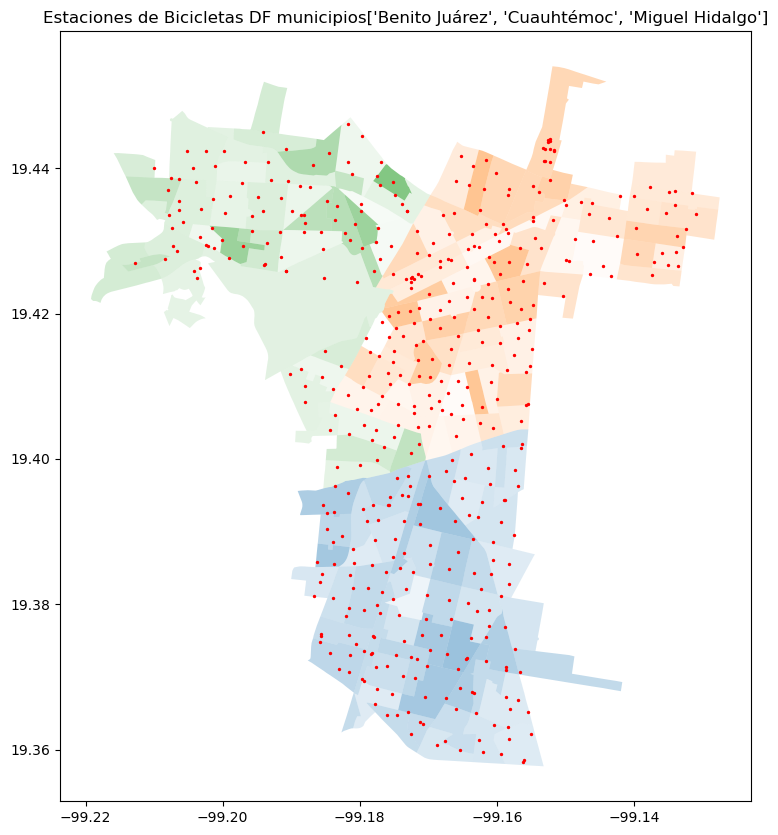

In [32]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: plt.cm.tab10(i) for i, municipio in enumerate(poligonos_seleccionados['municipio'].unique())}

# Mapea los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ajusta la intensidad del color basada en la población total
poblacion_maxima = poblacion['pob_total'].max()  # Obtén el valor máximo de población total
intensidades = poblacion['pob_total'] / poblacion_maxima  # Normaliza la población total

# Ajusta la transparencia de los colores según las intensidades
colores_alpha = [(color[0], color[1], color[2], intensidad) for color, intensidad in zip(colores, intensidades)]

# Plotea el DataFrame 'poligonos_seleccionados' utilizando los colores y transparencias
poligonos_seleccionados.plot(ax=ax, color=colores_alpha)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [33]:
# Función para crear una imagen con polígonos seleccionados
def crear_imagen_poligonos(titulo):
    fig, ax = plt.subplots(figsize=(10, 10))
    poligonos_seleccionados.plot(ax=ax, color=colores)
    ax.set_title(titulo)
    ax.axis('off')  # Desactiva los ejes
    plt.tight_layout()
    return fig

# Función para agregar estaciones y líneas a la imagen
def agregar_estaciones_y_lineas(fig, estaciones, paso):
    ax = fig.gca()  # Obtiene el eje actual
    for i in range(paso + 1):  # Dibuja todas las estaciones hasta el paso actual
        estacion = estaciones.iloc[i]
        ax.plot(estacion.geometry.x, estacion.geometry.y, 'ro')  # Agrega la estación
    if paso > 0:  # Solo dibuja la línea si hay al menos dos estaciones
        estacion_actual = estaciones.iloc[paso]
        estacion_anterior = estaciones.iloc[paso-1]
        ax.plot([estacion_anterior.geometry.x, estacion_actual.geometry.x], 
                [estacion_anterior.geometry.y, estacion_actual.geometry.y], 'k-')  # Agrega la línea
    return fig


# Crear una lista de imágenes para cada paso
imagenes = []
for i in range(len(estaciones_gdf)):
    # Crear la imagen con polígonos seleccionados
    titulo = f'Crecimiento del sistema de transporte ECOBICI - Estación {i+1}/{len(estaciones_gdf)}'
    fig = crear_imagen_poligonos(titulo)
    # Agregar estaciones y líneas hasta el paso actual
    fig = agregar_estaciones_y_lineas(fig, estaciones_gdf, i)
    # Guardar la imagen
    filename = f'imagen_{i}.png'
    fig.savefig(filename)
    plt.close(fig)  # Cerrar la figura para liberar memoria
    imagenes.append(filename)

# Crear la última imagen con todos los puntos pero sin la última línea
titulo_final = f'Crecimiento del sistema de transporte ECOBICI - Final'
fig_final = crear_imagen_poligonos(titulo_final)
estaciones_gdf.plot(ax=fig_final.gca(), marker='o', color='red', markersize=30)
fig_final.savefig('imagen_final.png')
plt.close(fig_final)
imagenes.append('imagen_final.png')

# Obtener el número de cuadros y el intervalo de tiempo entre ellos
num_cuadros = len(imagenes)
duracion_total = 20  # Duración total de la animación en segundos
intervalo_tiempo = duracion_total / num_cuadros  # Intervalo de tiempo entre cada cuadro

# Crear el GIF con la duración total especificada
with imageio.get_writer('animacion.gif', mode='I', duration=intervalo_tiempo) as writer:
    for filename in imagenes:
        imagen = imageio.v2.imread(filename)
        writer.append_data(imagen)

In [34]:
# Limpiar archivos de imagen
for filename in set(imagenes):
    os.remove(filename)

In [69]:
dataframes = []
cuadro_1 = pd.read_csv('2018-01.csv')
dataframes.append(cuadro_1)
cuadro_2 = pd.read_csv('ecobici_2023_01.csv')
dataframes.append(cuadro_2)
cuadro_3 = pd.read_csv('ecobici_2024_enero.csv')
dataframes.append(cuadro_3)
combined_csv = pd.concat(dataframes)
combined_csv.to_csv('combined_file.csv', index=False)

C:\Users\Administrador\AppData\Local\Temp\ipykernel_19268\3778920959.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cuadro_1 = pd.read_csv('2018-01.csv')


In [70]:
len(cuadro_1), len(cuadro_2), len(cuadro_3)

(686292, 586433, 1558100)

In [35]:
combined_csv = pd.read_csv('combined_file_All.csv')
#del cuadro_1, cuadro_2, cuadro_3

/var/folders/dq/sptc86px36g5fbb_9g_bhzrh0000gn/T/ipykernel_21104/3030477441.py:1: DtypeWarning: Columns (2,3,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_csv = pd.read_csv('combined_file_All.csv')


In [36]:
#combined_csv = combined_csv_2

In [42]:
combined_csv.sort_values(by='Fecha_Arribo', ascending=True).head()

Genero_Usuario  Edad_Usuario  Bici  Ciclo_Estacion_Retiro  \
4989837              M          47.0  9956                     21   
4989906              M          38.0  2582                    125   
4989905              M          35.0  3869                     63   
4989904              M          39.0  8548                    326   
4989903              M          29.0  6942                     64   

        Fecha_Retiro Hora_Retiro  Ciclo_Estacion_Arribo Fecha_Arribo  \
4989837   2018-01-01    14:35:26                     20   2018-01-01   
4989906   2018-01-01    14:48:02                    127   2018-01-01   
4989905   2018-01-01    14:47:22                    137   2018-01-01   
4989904   2018-01-01    14:47:17                     74   2018-01-01   
4989903   2018-01-01    14:46:59                     21   2018-01-01   

        Hora_Arribo  
4989837    14:47:21  
4989906    14:50:01  
4989905    15:00:00  
4989904    15:00:16  
4989903    14:54:33

In [37]:
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].combine_first(combined_csv['Ciclo_EstacionArribo'])
combined_csv['Fecha_Arribo'] = combined_csv['Fecha_Arribo'].combine_first(combined_csv['Fecha Arribo'])
combined_csv.drop(columns=['Ciclo_EstacionArribo', 'Fecha Arribo'], inplace=True)

In [38]:
combined_csv['Fecha_Retiro'] = pd.to_datetime(combined_csv['Fecha_Retiro'], format='%d/%m/%Y')
combined_csv['Fecha_Arribo'] = pd.to_datetime(combined_csv['Fecha_Arribo'], format='%d/%m/%Y')
combined_csv['Hora_Retiro'] = pd.to_datetime(combined_csv['Hora_Retiro'], format='%H:%M:%S').dt.time
combined_csv['Hora_Arribo'] = pd.to_datetime(combined_csv['Hora_Arribo'], format='%H:%M:%S').dt.time

### Limpieza Extra

In [39]:
combined_csv_2 = combined_csv

In [40]:
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].astype(str).str.split('-').str[0]
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].astype(str).str.split('-').str[0]

In [41]:
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].astype(str).str.extract('(\d+)')
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].fillna(0).astype(int) 

combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].astype(str).str.extract('(\d+)')
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].fillna(0).astype(int) 

In [42]:
combined_csv = combined_csv[(combined_csv['Ciclo_Estacion_Retiro'] > 0) & (combined_csv['Ciclo_Estacion_Retiro'] <= 480)].copy()
combined_csv = combined_csv[(combined_csv['Ciclo_Estacion_Arribo'] > 0) & (combined_csv['Ciclo_Estacion_Arribo'] <= 480)].copy()

In [43]:
combined_csv['Ciclo_Estacion_Arribo'].value_counts

<bound method IndexOpsMixin.value_counts of 0           133
1            52
2             9
3           111
4           155
           ... 
23975310    136
23975311    162
23975312    151
23975313    287
23975314    162
Name: Ciclo_Estacion_Arribo, Length: 21663267, dtype: int64>

### Calcular el Delta Time

In [44]:
combined_csv['Retiro'] = pd.to_datetime(combined_csv['Fecha_Retiro'].astype(str) + ' ' + combined_csv['Hora_Retiro'].astype(str))
combined_csv['Arribo'] = pd.to_datetime(combined_csv['Fecha_Arribo'].astype(str) + ' ' + combined_csv['Hora_Arribo'].astype(str))
combined_csv['Delta_time'] = combined_csv['Arribo'] - combined_csv['Retiro']

In [45]:
combined_csv['Delta_time_minutes'] = combined_csv['Delta_time'].dt.total_seconds() / 60
combined_csv['Año'] = combined_csv['Fecha_Arribo'].dt.year

In [46]:
combined_csv.columns

Index(['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro',
       'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_Estacion_Arribo', 'Fecha_Arribo',
       'Hora_Arribo', 'Retiro', 'Arribo', 'Delta_time', 'Delta_time_minutes',
       'Año'],
      dtype='object')

In [47]:
combined_csv_hora = combined_csv[combined_csv['Delta_time_minutes'] <= 60].copy()
combined_csv_dia = combined_csv[(combined_csv['Delta_time_minutes'] > 60) & (combined_csv['Delta_time_minutes'] <= 300)].copy()
combined_csv_todo = combined_csv[(combined_csv['Delta_time_minutes'] > 300) & (combined_csv['Delta_time_minutes'] <= 1440)].copy()

In [51]:
combined_csv_hora.sort_values(by='Fecha_Arribo', ascending=True)

Genero_Usuario  Edad_Usuario     Bici  Ciclo_Estacion_Retiro  \
4989801               F          28.0     1455                     47   
4989906               M          38.0     2582                    125   
4989905               M          35.0     3869                     63   
4989904               M          39.0     8548                    326   
4989903               M          29.0     6942                     64   
...                 ...           ...      ...                    ...   
11387946              M          28.0  7830227                     48   
11387947              M          53.0  6801344                     95   
11387948              M          19.0  3607116                    329   
11387950              M          31.0  2581361                     23   
11424403              M          39.0  8400822                    334   

         Fecha_Retiro Hora_Retiro  Ciclo_Estacion_Arribo Fecha_Arribo  \
4989801    2018-01-01    14:29:57                     84   2018-01-01   
4989906    2018-01-01    14:48:02                    127   2018-01-01   
4989905    2018-01-01    14:47:22                    137   2018-01-01   
4989904    2018-01-01    14:47:17                     74   2018-01-01   
4989903    2018-01-01    14:46:59                     21   2018-01-01   
...               ...         ...                    ...          ...   
11387946   2024-02-29    12:28:44                     48   2024-02-29   
11387947   2024-02-29    12:23:30                    122   2024-02-29   
11387948   2024-02-29    12:18:33                    141   2024-02-29   
11387950   2024-02-29    11:59:14                     15   2024-02-29   
11424403   2024-02-29    19:46:29                    381   2024-02-29   

         Hora_Arribo              Retiro              Arribo      Delta_time  \
4989801     15:05:54 2018-01-01 14:29:57 2018-01-01 15:05:54 0 days 00:35:57   
4989906     14:50:01 2018-01-01 14:48:02 2018-01-01 14:50:01 0 days 00:01:59   
4989905     15:00:00 2018-01-01 14:47:22 2018-01-01 15:00:00 0 days 00:12:38   
4989904     15:00:16 2018-01-01 14:47:17 2018-01-01 15:00:16 0 days 00:12:59   
4989903     14:54:33 2018-01-01 14:46:59 2018-01-01 14:54:33 0 days 00:07:34   
...              ...                 ...                 ...             ...   
11387946    12:35:24 2024-02-29 12:28:44 2024-02-29 12:35:24 0 days 00:06:40   
11387947    12:35:25 2024-02-29 12:23:30 2024-02-29 12:35:25 0 days 00:11:55   
11387948    12:35:26 2024-02-29 12:18:33 2024-02-29 12:35:26 0 days 00:16:53   
11387950    12:35:27 2024-02-29 11:59:14 2024-02-29 12:35:27 0 days 00:36:13   
11424403    19:52:35 2024-02-29 19:46:29 2024-02-29 19:52:35 0 days 00:06:06   

          Delta_time_minutes   Año  
4989801            35.950000  2018  
4989906             1.983333  2018  
4989905            12.633333  2018  
4989904            12.983333  2018  
4989903             7.566667  2018  
...                      ...   ...  
11387946            6.666667  2024  
11387947           11.916667  2024  
11387948           16.883333  2024  
11387950           36.216667  2024  
11424403            6.100000  2024  

[21527147 rows x 14 columns]

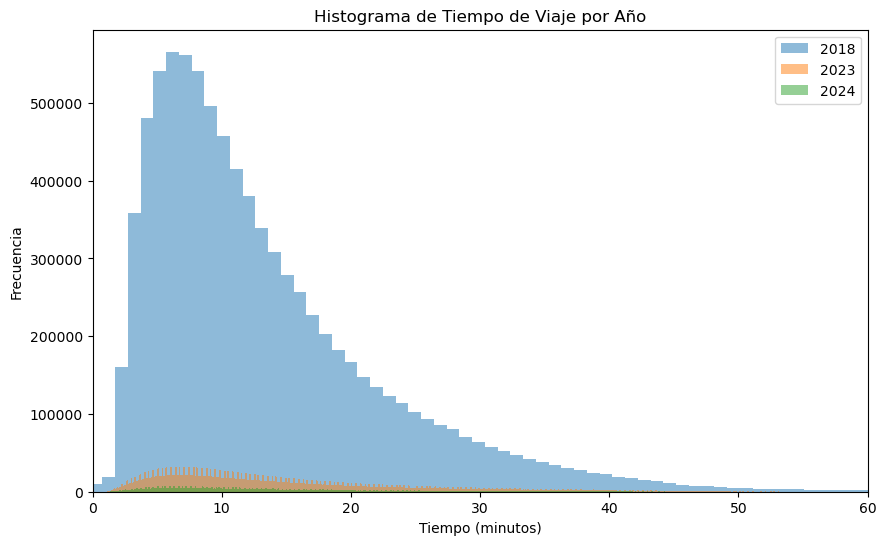

In [48]:

fig, ax = plt.subplots(figsize=(10, 6))

for año, datos_año in combined_csv_hora.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=1500, alpha=0.5, label=str(año))

ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.set_xlim(0,60)
ax.legend()

plt.show()

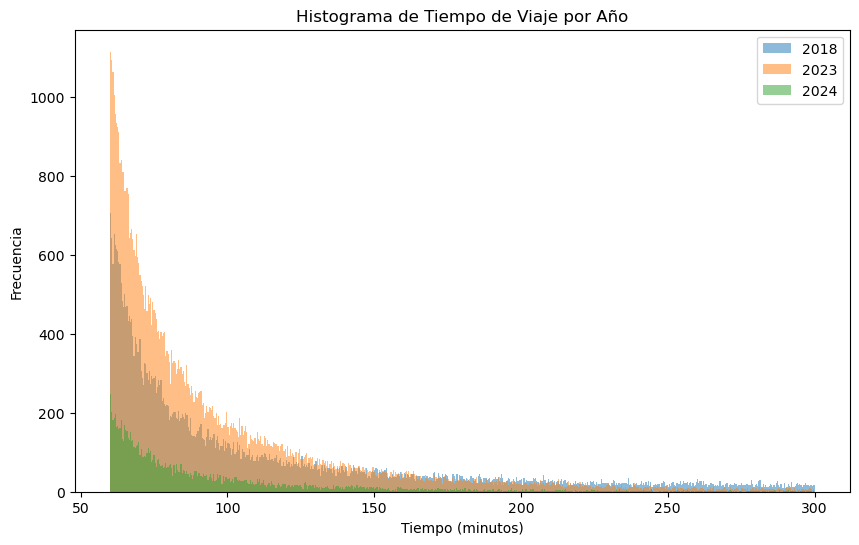

In [49]:

fig, ax = plt.subplots(figsize=(10, 6))

for año, datos_año in combined_csv_dia.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=600, alpha=0.5, label=str(año))

ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.legend()


plt.show()

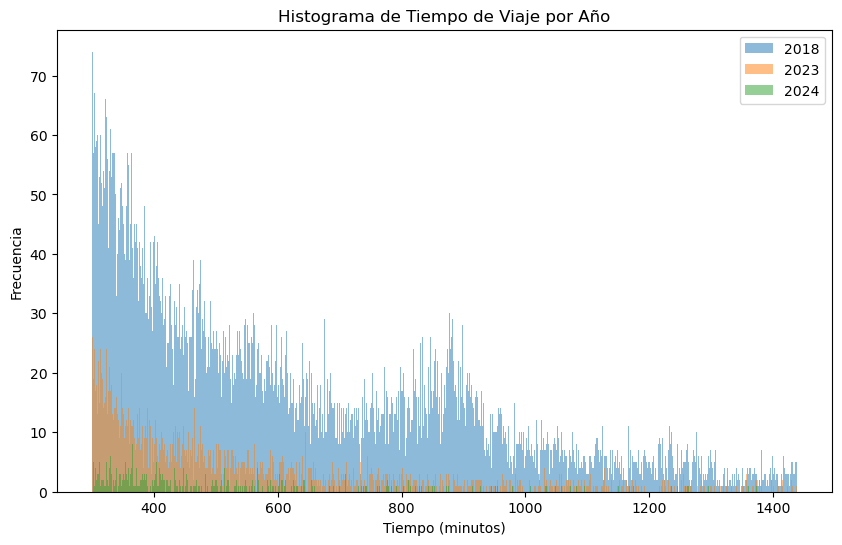

In [50]:

fig, ax = plt.subplots(figsize=(10, 6))

for año, datos_año in combined_csv_todo.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=800, alpha=0.5, label=str(año))

ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.legend()

# Mostrar el gráfico
plt.show()

### Estimación de Kernel 

In [105]:
combined_atipicos = combined_csv[(combined_csv['Delta_time_minutes'] > 1440) | (combined_csv['Delta_time_minutes'] <= 0)]
combined_tipicos = combined_csv[(combined_csv['Delta_time_minutes'] <= 1440) & (combined_csv['Delta_time_minutes'] > 0)]

In [106]:
combined_tipicos_60_min = combined_tipicos[(combined_tipicos['Delta_time_minutes'] <= 60)]

In [107]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV

### KDE con diferentes Kernels

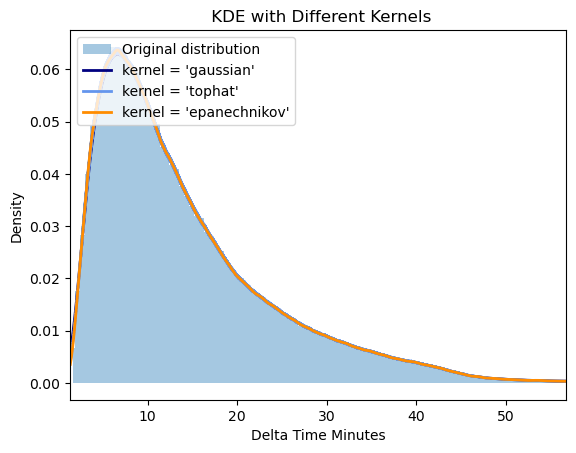

In [108]:
sample_size = min(len(combined_tipicos_60_min), 1000000) 
sampled_data = combined_tipicos_60_min.sample(n=sample_size, random_state=1)

X = sampled_data['Delta_time_minutes'].values[:, np.newaxis]
min_value, max_value = np.percentile(X, [0.1, 99.9])
X_plot = np.linspace(min_value, max_value, 10000)[:, np.newaxis]

fig, ax = plt.subplots()
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

hist, bins = np.histogram(X, bins=100, range=(min_value, max_value), density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
ax.fill_between(bin_centers, hist, step="mid", alpha=0.4, label='Original distribution')

for color, kernel in zip(colors, kernels):
    bandwidth = np.std(X) * (4 / (3 * len(X))) ** (1 / 5)  
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw, linestyle='-', label=f"kernel = '{kernel}'")

ax.legend(loc='upper left')
ax.set_title(' KDE with Different Kernels')
ax.set_xlabel('Delta Time Minutes')
ax.set_ylabel('Density')
ax.set_xlim(min_value, max_value)
plt.show()

### Silverman's rule

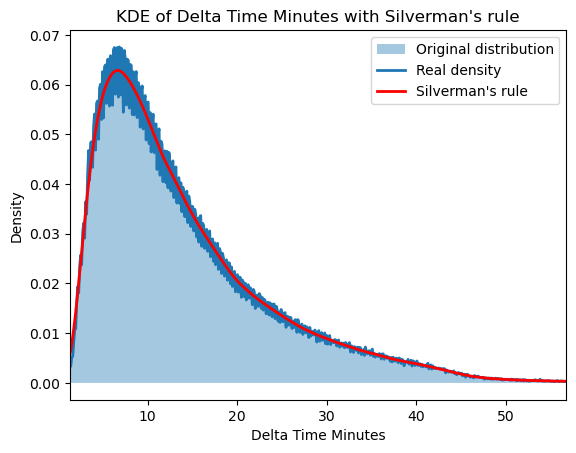

In [110]:
sample_size = min(len(combined_tipicos_60_min), 1000000) 
sampled_data = combined_tipicos_60_min.sample(n=sample_size, random_state=1)

X = sampled_data['Delta_time_minutes'].values[:, np.newaxis]
silverman_bandwidth = 1.06 * X.std() * len(X) ** (-1 / 5.)

min_value, max_value = np.percentile(X, [0.1, 99.9]) 
X_plot = np.linspace(min_value, max_value, 1000)[:, np.newaxis]

fig, ax = plt.subplots()

hist, bin_edges = np.histogram(X, bins=500, range=(min_value, max_value), density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.fill_between(bin_centers, hist, step="mid", alpha=0.4, label='Original distribution')

ax.plot(bin_centers, hist, linestyle='-', lw=2, label='Real density')

kde = KernelDensity(kernel='gaussian', bandwidth=silverman_bandwidth).fit(X)
log_dens = kde.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens), color='red', lw=2, linestyle='-', label="Silverman's rule")


ax.legend(loc='upper right')
ax.set_title('KDE of Delta Time Minutes with Silverman\'s rule')
ax.set_xlabel('Delta Time Minutes')
ax.set_ylabel('Density')
ax.set_xlim(min_value, max_value)

plt.show()

### Sheather and Jones method

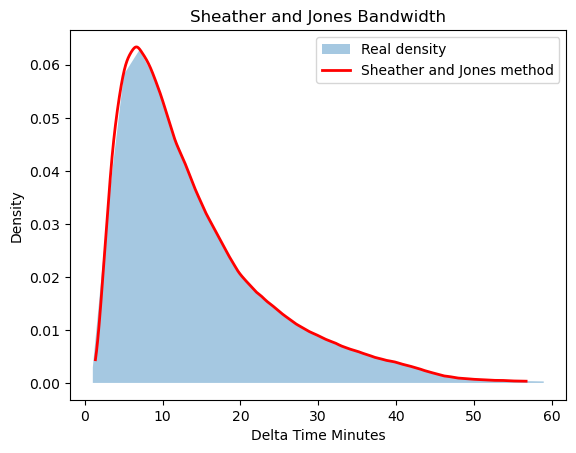

In [109]:
bandwidths = 10 ** np.linspace(-1, 1, 20)

subset_size = min(len(X), 10000)
subset_indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X[subset_indices]

grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=5, n_jobs=-1)  
grid.fit(X_subset)
sj_bandwidth = grid.best_params_['bandwidth']


fig, ax = plt.subplots()

hist, bin_edges = np.histogram(X, bins=30, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.fill_between(bin_centers, hist, alpha=0.4, label='Real density')


kde_sj = KernelDensity(kernel='gaussian', bandwidth=sj_bandwidth).fit(X)
log_dens_sj = kde_sj.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens_sj), color='red', lw=2, linestyle='-', label='Sheather and Jones method')

ax.legend(loc='upper right')
ax.set_title('Sheather and Jones Bandwidth')
ax.set_xlabel('Delta Time Minutes')
ax.set_ylabel('Density')

plt.show()

### Scott’s method

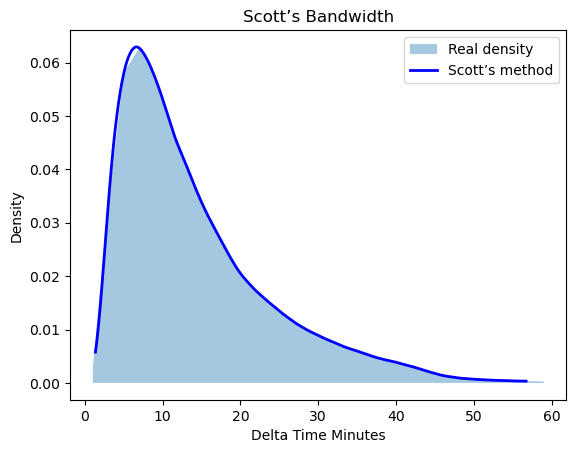

In [111]:
sample_size = min(len(combined_tipicos_60_min), 1000000) 
sampled_data = combined_tipicos_60_min.sample(n=sample_size, random_state=1)

X = sampled_data['Delta_time_minutes'].values[:, np.newaxis]
scott_bandwidth = X.std() * len(X) ** (-1/5.)

fig, ax = plt.subplots()

hist, bin_edges = np.histogram(X, bins=30, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.fill_between(bin_centers, hist, alpha=0.4, label='Real density')

kde_scott = KernelDensity(kernel='gaussian', bandwidth=scott_bandwidth).fit(X)
log_dens_scott = kde_scott.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens_scott), color='blue', lw=2, linestyle='-', label='Scott’s method')

ax.legend(loc='upper right')
ax.set_title('Scott’s Bandwidth')
ax.set_xlabel('Delta Time Minutes')
ax.set_ylabel('Density')

plt.show()


### Grafo

In [94]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  
    return c * r

combined_csv_hora = combined_csv_hora.merge(estaciones_gdf, left_on='Ciclo_Estacion_Retiro', right_on='id')\
    .rename(columns={'lat': 'lat_retiro', 'lon': 'lon_retiro'})\
    .drop(columns='id')\
    .merge(estaciones_gdf, left_on='Ciclo_Estacion_Arribo', right_on='id')\
    .rename(columns={'lat': 'lat_arribo', 'lon': 'lon_arribo'})\
    .drop(columns='id')

combined_csv_hora['distancia'] = combined_csv_hora.apply(
    lambda row: haversine(row['lat_retiro'], row['lon_retiro'], row['lat_arribo'], row['lon_arribo']), axis=1)


In [96]:
combined_csv_hora.to_csv('combined_csv_hora.csv', index=False)

In [227]:
import json
with open('stations.json', 'r') as file:
    stations_data = json.load(file)

stations_df = pd.json_normalize(stations_data['stations'])


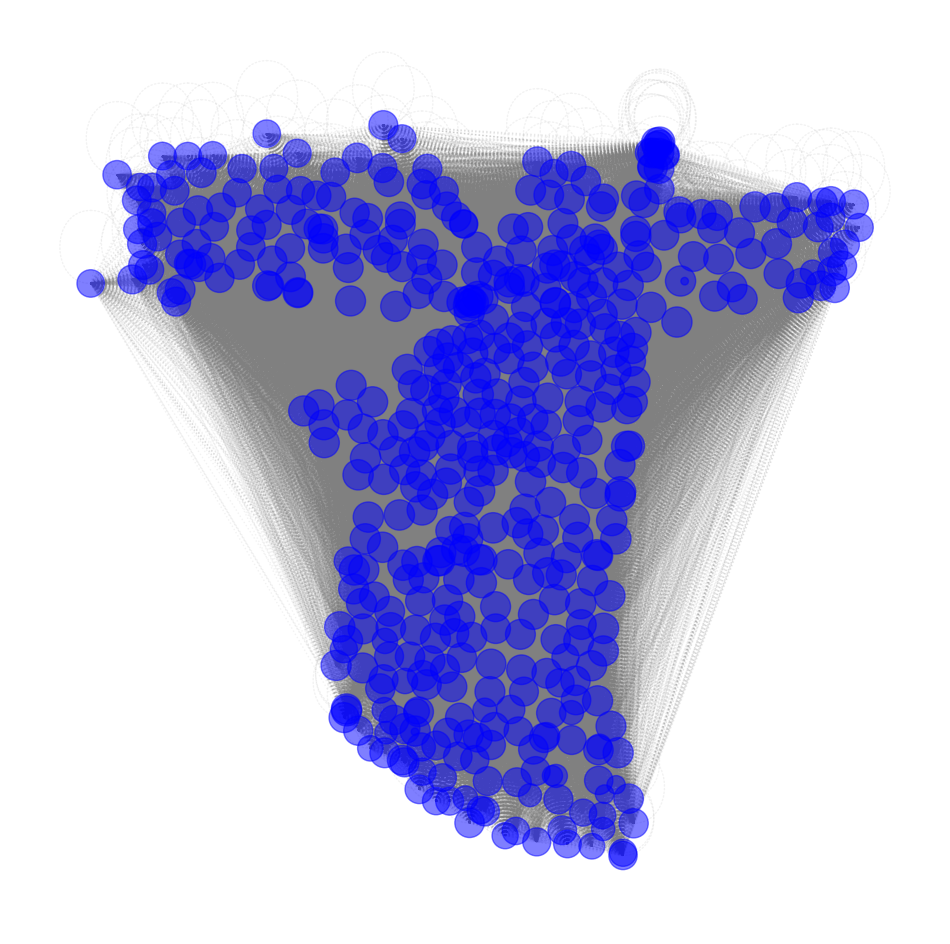

In [286]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

edge_weights = combined_csv_hora.groupby(['Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo']).size().reset_index(name='weight')

G = nx.Graph()

pos = {}
for index, row in stations_df.iterrows():
    G.add_node(row['id'], **row.to_dict())
    pos[row['id']] = (row['location.lon'], row['location.lat'])

for _, row in edge_weights.iterrows():
    start_station = row['Ciclo_Estacion_Retiro']
    end_station = row['Ciclo_Estacion_Arribo']
    weight = row['weight']
    if G.has_node(start_station) and G.has_node(end_station):
        G.add_edge(start_station, end_station, weight=weight)

node_sizes = [G.degree(n) for n in G]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G=G, pos=pos, node_size=node_sizes, node_color='blue', alpha=0.5)
nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)
plt.axis('off')
plt.show()


In [102]:
import community.community_louvain as cl

In [219]:
import matplotlib.cm as cm


def communityLouvain(G, pos):
    fig, ax = plt.subplots(figsize=(20,11))

    partition = cl.best_partition(G, weight='weight', resolution=0.99999, random_state=12)

    cmap = plt.cm.get_cmap('tab20b', max(partition.values()) + 1)

    nodes = nx.draw_networkx_nodes(G, pos=pos, node_size=40, cmap=cmap, node_color=list(partition.values()))
    edges = nx.draw_networkx_edges(G, pos=pos, alpha=0.015)

    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(partition.values()), vmax=max(partition.values())))
    sm._A = [] 
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Community', rotation=270, labelpad=15)

    for community_id, color in enumerate(cmap.colors):
        ax.plot([], [], color=color, label=f'Community {community_id}')

    ax.set_title('Red ECOBICI', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    ax.text(0.99, 0.01, '© Github/jeyner777',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    ax.legend()

    plt.show()

/var/folders/dq/sptc86px36g5fbb_9g_bhzrh0000gn/T/ipykernel_21104/1622887713.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', max(partition.values()) + 1)


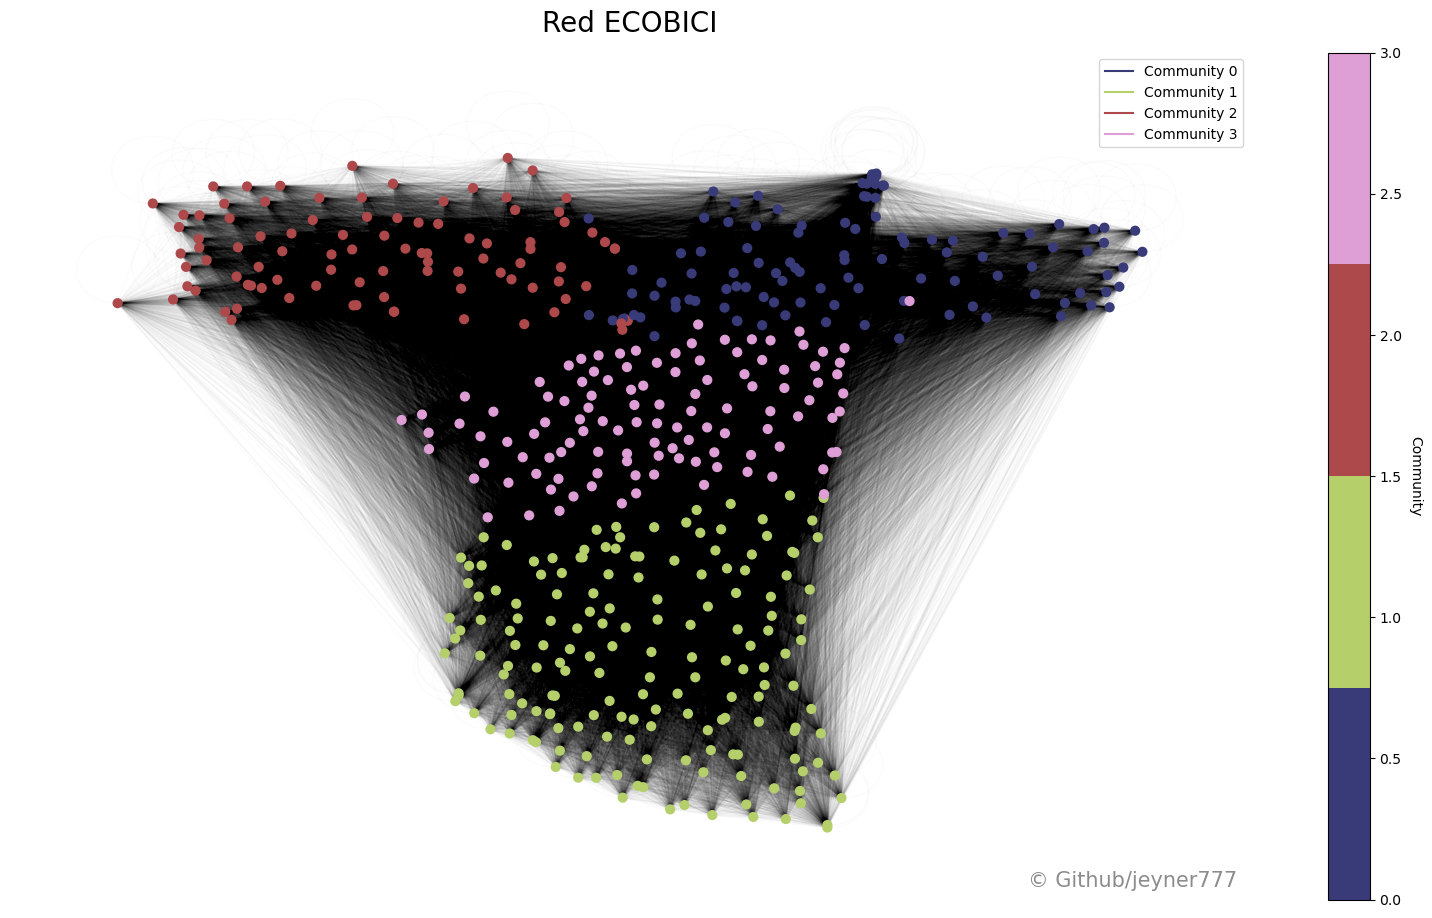

In [220]:
pos = {}
for index, row in stations_df.iterrows():
    G.add_node(row['id'], **row.to_dict())
    pos[row['id']] = (row['location.lon'], row['location.lat'])

communityLouvain(G, pos)

/var/folders/dq/sptc86px36g5fbb_9g_bhzrh0000gn/T/ipykernel_21104/3289815024.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)


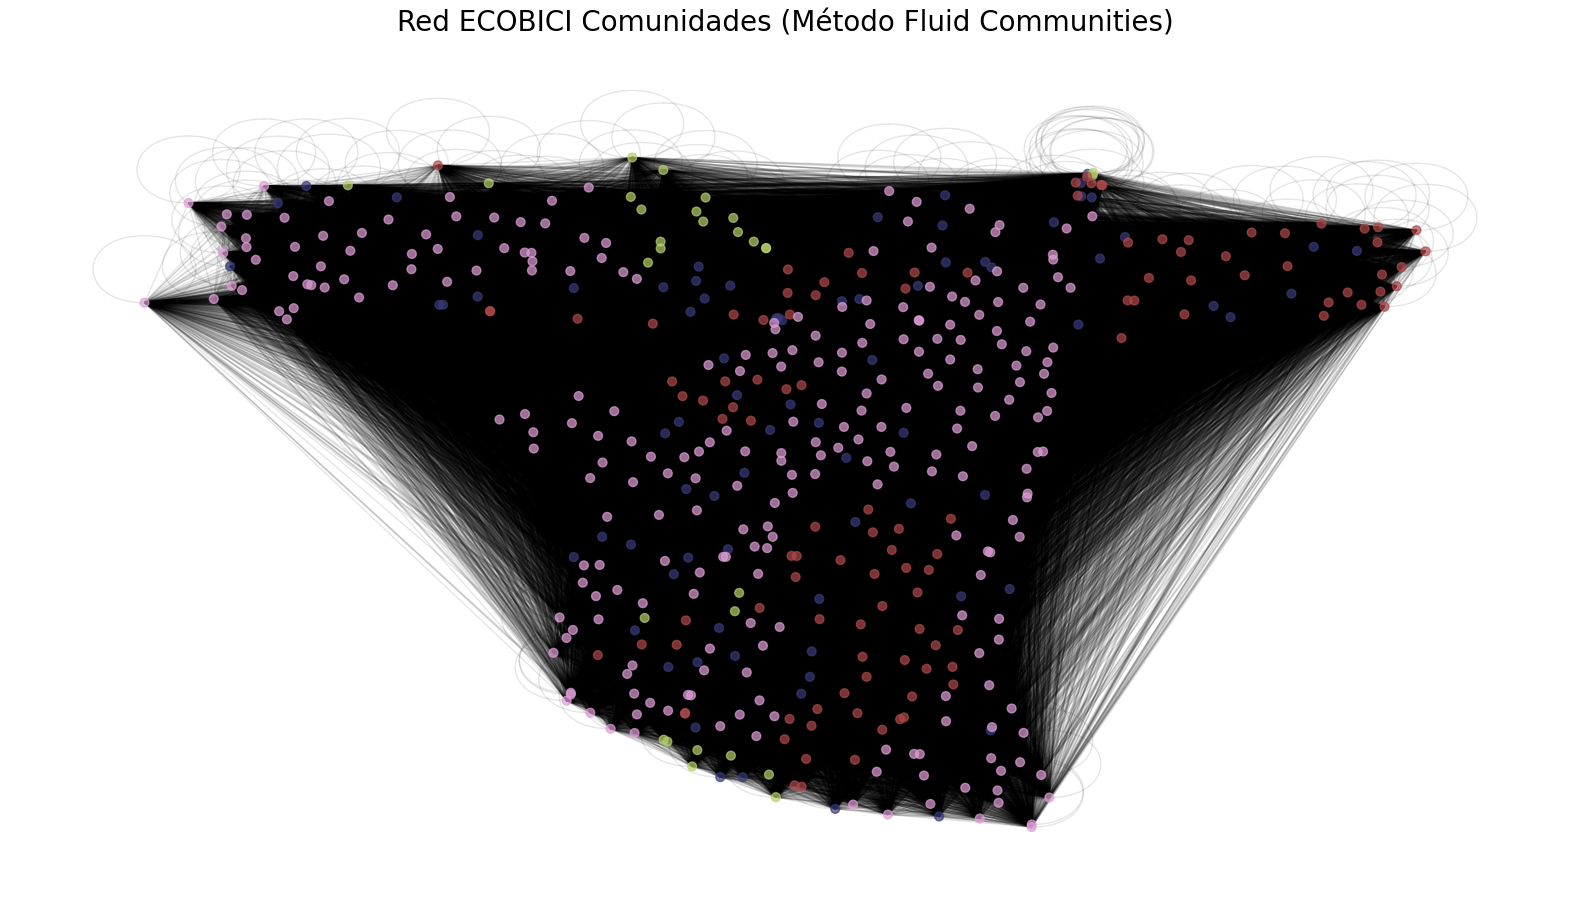

In [283]:

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

def communityFluid(G, pos, k=7):
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(G, k=k, max_iter=10000, seed=12)
    
    partition = {}
    for idx, community in enumerate(communities):
        for node in community:
            partition[node] = idx

    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    fig, ax = plt.subplots(figsize=(20, 11))


    nx.draw_networkx_nodes(G, pos=pos, node_size=40, cmap=cmap, node_color=list(partition.values()), alpha=0.7)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.1)
    ax.set_title('Red ECOBICI Comunidades (Método Fluid Communities)', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    plt.show()


pos = {row['id']: (row['location.lon'], row['location.lat']) for index, row in stations_df.iterrows()}
G.add_nodes_from(pos.keys())

communityFluid(G, pos, k=4) 


### K MEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import davies_bouldin_score

In [275]:
with open('graph.json', 'r') as file:
    data = json.load(file)

nodes = data['nodes']

node_features = []
for node in nodes:

    node_features.append([
        node.get('id', None),

        node.get('location.lat', {}),
        node.get('location.lon', {})
    ])

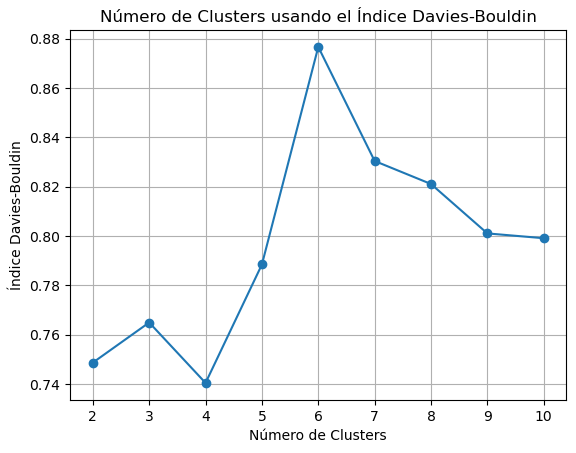

In [277]:
davies_bouldin_scores = []
X = estaciones_gdf[['lon', 'lat']].values

for num_clusters in range(2, 11): 
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X) 
    score = davies_bouldin_score(X, clusters)

    davies_bouldin_scores.append(score)

plt.plot(range(2, 11), davies_bouldin_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice Davies-Bouldin')
plt.title('Número de Clusters usando el Índice Davies-Bouldin')
plt.grid(True)
plt.show()

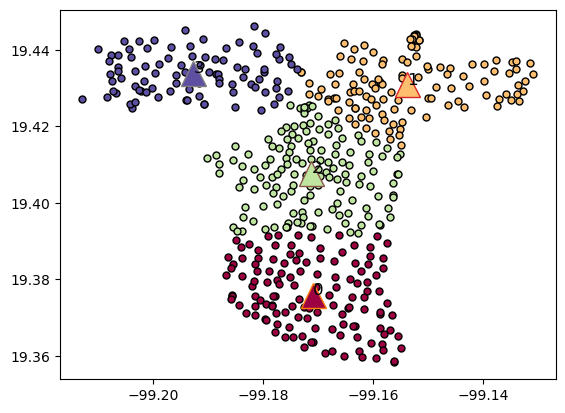

In [279]:
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import davies_bouldin_score
import matplotlib.image as mpimg

n_clusters_ = 4

kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++', n_init=10)
kmeans.fit(X) 
labels = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_ 
estaciones_gdf['clusters']=labels
estaciones_gdf.index=estaciones_gdf['id']
cluster_map = estaciones_gdf['clusters'].to_dict()
combined_csv_hora['de_station_c']=combined_csv_hora['Ciclo_Estacion_Retiro'].map(cluster_map)
combined_csv_hora['a_station_c']=combined_csv_hora['Ciclo_Estacion_Arribo'].map(cluster_map)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
BBox = (-79.4900,-79.2700,43.6100,43.7200)

fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12)

plt.show()